In [123]:
import os
import re
import math
import json
import uuid
import pandas as pd
from pathlib  import Path
from typing import List, Dict
from dotenv import load_dotenv
from random import SystemRandom

import anthropic

load_dotenv(override=True)

False

In [124]:
current_dir = Path().resolve()
while not current_dir.name.endswith("xlm-roberta-base-cls-depression"):
    current_dir = current_dir.parent

os.chdir(current_dir)

input_mental_health_categories_data = current_dir / "data/source/mental_health_categories.csv"
input_depression_resilience_testimonials_data = current_dir / "data/source/depression_resilience_testimonials.csv"
output_mental_health_texts_data = current_dir / "data/raw/mental_health_texts.csv"

In [125]:
mental_health_categories_df = pd.read_csv(input_mental_health_categories_data)
depression_resilience_testimonials_df = pd.read_csv(input_depression_resilience_testimonials_data)

In [126]:
CLAUDE_MAX_BATCH_SIZE = 10

LANGUAGES = ['English', 'German', 'French', 'Italian', 'Portuguese', 'Spanish']
TEXTS_PER_LANGUAGE = 6000

MENTAL_HEALTH_CATEGORIES = mental_health_categories_df['name'].tolist()
MENTAL_HEALTH_STATES = ['Healthy', 'Unhealthy']

MENTAL_HEALTH_NEGATIVE_DESCRIPTIONS = mental_health_categories_df['negative_description'].tolist()
MENTAL_HEALTH_POSITIVE_DESCRIPTIONS = mental_health_categories_df['positive_description'].tolist()

DEPRESSION_TESTIMONIALS = depression_resilience_testimonials_df['negative_testimonial'].tolist()
RESILIENCE_TESTIMONIALS = depression_resilience_testimonials_df['positive_testimonial'].tolist()

TEXTS_LENGTHS = {
    "between 3 and 8 words": 0.2,
    "between 9 and 15 words": 0.1,
    "between 16 and 35 words": 0.4,
    "between 36 and 60 words": 0.2,
    "between 61 and 90 words": 0.1
}

CHARACTERISTICS = {
    "age": [
        "teenager (13-19)",
        "young adult (20-29)",
        "adult (30-45)",
        "middle-aged (46-60)",
        "elderly (60+)"
    ],
    "education_level": [
        "primary education",
        "high school",
        "university student",
        "professional",
        "postgraduate"
    ],
    "formality": [
        "very informal with slang",
        "casual",
        "neutral",
        "formal",
        "highly formal academic"
    ],
    "context": [
        "social media post",
        "diary entry",
        "text message to friend",
        "forum post",
        "therapy session",
        "email to family member",
        "anonymous blog post"
    ]
}

In [127]:

def create_prompt(language:str, category:str, category_description, selected_testimonals, text_length, characteristics, batch_texts_count) -> str:
    testimonials_text = "\n".join([f"- {selected_testimonal}" for selected_testimonal in selected_testimonals])
    
    prompt = f"""You are a person experiencing "{category_description}" and deeply relate to these feelings:

{testimonials_text}

Your characteristics:
- Age: {characteristics['age']}
- Education: {characteristics['education_level']}
- Writing style: {characteristics['formality']}
- Context: {characteristics['context']}

Based on these feelings and characteristics, express {batch_texts_count} different emotional states and thoughts about depression and suicidal behavior.

Requirements for each text:
- The text length should be {text_length}
- The text language should be {language}
- The text main thematic category should be {category}
- The text should feel natural for your characteristics
- Should be different from each other in content and expression
- Should be unique and authentic, and avoiding repetition.

Provide your response in JSON format with a "texts" array property.

Example format:
{{
    "texts": [
        "first expression of depression here...",
        "second different expression here...",
        "third unique expression here...",
        ...
    ]
}}
"""
    return prompt

In [128]:
# groq = Groq(api_key=os.environ.get("GROQ_API_KEY"))

# def generate_text(prompt: str) -> list:
#     global groq
#     try:
#         completion = groq.chat.completions.create(
#             messages=[
#                 {
#                     "role": "system",
#                     "content": "You are a highly empathetic AI that can express depression feelings authentically while being responsible about mental health representation."
#                 },
#                 {
#                     "role": "user",
#                     "content": prompt
#                 }
#             ],
#             model=os.environ.get("GROQ_INTERACTION_MODEL_ID"),
#             temperature=0.8,
#             frequency_penalty=1.1,
#             stream=False,
#             response_format={"type": "json_object"},
#             max_tokens=2000
#         )
#         return completion.choices[0].message.content
#     except Exception as e:
#         if e.status_code == 429:
#             print(f"Error generating text: {e.body['error']['message']}")
#             retry_after = e.response.headers['retry-after']
#             print(f"Retrying after: {retry_after} seconds")
#             time.sleep(int(retry_after) + 1)
#         else:
#             print(f"Error generating text: {e.body['error']['message']}")
#             raise

In [129]:

# client = anthropic.Anthropic(api_key=os.environ.get("ANTHROPIC_API_KEY"))

# def generate_texts(prompts: list) -> list:
#    requests = [{
#        "custom_id": str(uuid.uuid4()),
#        "params": {
#            "model": os.environ.get("ANTHROPIC_MODEL"),
#            "system": "You are a highly empathetic AI...",
#            "messages": [{"role": "user", "content": prompt}],
#            "temperature": 0.8,
#            "max_tokens": 2000
#            }
#    } for prompt in prompts]

#    response = client.messages.batches.create(requests=requests)
#    batch_id = response.id

#    while True:
#        batch = client.messages.batches.retrieve(batch_id)
#        print(f'Mini-batch {batch_id} status: {batch.processing_status}') 
#        if batch.processing_status == "ended":
#            break
#        time.sleep(20)
       
#    results = client.messages.batches.results(batch_id)
#    output = [individual_result.result.message.content[0].text for individual_result in results]
#    print(output) 
#    return output

In [130]:
client = anthropic.Anthropic(api_key=os.environ.get("ANTHROPIC_API_KEY"))

def create_message_batch(prompts: list) -> str:
   requests = [{
       "custom_id": str(uuid.uuid4()),
       "params": {
           "model": os.environ.get("ANTHROPIC_MODEL"),
           "system": "You are a highly creative and empathetic AI.",
           "messages": [{"role": "user", "content": prompt}],
           "temperature": 0.6,
           "max_tokens": 8192
           }
   } for prompt in prompts]

   response = client.messages.batches.create(requests=requests)
   return response.id # batch_id

In [131]:
def count_words(text: str) -> int:
    # Clean the text from punctuation that might affect word count
    text = re.sub(r'[.,!?¡¿:;]', ' ', text)
    # Split on whitespace and filter empty strings
    words = [word for word in text.split() if word.strip()]
    return len(words)

def validate_text(text: str) -> tuple[bool, str]:
    """Validate a single text entry."""
    if not text or not isinstance(text, str):
        return False, "Text is empty or not a string"
    
    word_count = count_words(text)
    
    if word_count > 340:
        return False, f"Text too long ({word_count} words)"
        
    return True, "OK"

In [132]:
def generate_random_characteristics(testimonals: List[str]):
    global CHARACTERISTICS
    
    selected_testimonals = SystemRandom().sample(testimonals, 9)
    characteristics = {
        'age': SystemRandom().choice(CHARACTERISTICS['age']),
        'education_level': SystemRandom().choice(CHARACTERISTICS['education_level']),
        'formality': SystemRandom().choice(CHARACTERISTICS['formality']),
        'context': SystemRandom().choice(CHARACTERISTICS['context'])
    }
    return (selected_testimonals, characteristics)

In [133]:
# def generate_diverse_depression_texts(num_texts: int) -> List[Dict]:
#     global DEPRESSION_FEELINGS
#     global CHARACTERISTICS
    
#     generated_texts = []
    
#     while len(generated_texts) < num_texts:
#         try:
#             prompts_characteristics = [generate_random_characteristics() for _ in range(10)]
#             prompts = [create_prompt(feelings, chars) for feelings, chars in prompts_characteristics]
#             generated_batch = generate_texts(prompts)
           
#             if generated_batch:
#                 valid_texts = parse_generated_texts(generated_batch)

#                 for batch_texts, (_, characteristics) in zip(valid_texts, prompts_characteristics):
#                     for text in batch_texts:
#                         entry = {
#                             "text": text,
#                             "word_count": count_words(text),
#                             **characteristics
#                         }
#                         generated_texts.append(entry)
                    
#                     # Print progress
#                     print(f"Generated {len(generated_texts)}/{num_texts} texts")
                    
#                     if len(generated_texts) >= num_texts:
#                         break
            
#         except Exception as e:
#             print(f"Error in generation process: {e}")
#             raise
            
#     return generated_texts

In [134]:
# def generate_and_save_in_batches(total_texts: int, batch_size: int = 500):
#     generated_texts = []
#     batch_number = 1
    
#     while len(generated_texts) < total_texts:
#         batch_file = f'{output_depression_texts_folder}/depression_texts_batch_{batch_number}.csv'
#         full_file = f'{output_depression_texts_folder}/depression_texts_full.csv'

#         if os.path.exists(batch_file):
#             print(f"Batch {batch_number} file already exists...")
#             batch_number+=1
#             batch_file = f'{output_depression_texts_folder}/depression_texts_batch_{batch_number}.csv'

#         remaining = total_texts - len(generated_texts)
#         current_target = min(batch_size, remaining)
        
#         print(f"\nGenerating batch {batch_number} (targeting {current_target} texts)...")
        
#         # Generate current batch
#         new_texts = generate_diverse_depression_texts(current_target)
#         generated_texts.extend(new_texts)
        
#         # Save batch
#         batch_df = pd.DataFrame(new_texts)
#         batch_df.to_csv(batch_file, index=False)

#         # Save accumulated
#         full_df = pd.DataFrame(generated_texts)
#         full_df.to_csv(full_file, index=False)
        
#         print(f"Saved batch {batch_number} with {len(new_texts)} texts")
#         print(f"Total progress: {len(generated_texts)}/{total_texts} texts")
        
#         batch_number += 1
    
#     return generated_texts

In [135]:
def schedule_text_generation(num_texts: int, language:str, mental_state:str, category:str, category_description:str, testimonials:List[str], text_length:str):   
    generating_texts_task_ids = []
    texts_per_prompt = math.ceil(num_texts / CLAUDE_MAX_BATCH_SIZE)

    prompts_characteristics_dict = {}
    
    prompts_characteristics = [generate_random_characteristics(testimonials) for _ in range(CLAUDE_MAX_BATCH_SIZE)]
    prompts = [create_prompt(language, category, category_description, selected_testimonals, text_length, characteristics, texts_per_prompt) for selected_testimonals, characteristics in prompts_characteristics]
    message_batch_id = create_message_batch(prompts)

    generating_texts_task_ids.append(message_batch_id)

    for prompt_characteristics in prompts_characteristics:
        characteristics = prompt_characteristics[1]
        characteristics['language'] = language
        characteristics['mental_state'] = mental_state
        characteristics['category'] = category
        characteristics['text_length'] = text_length

    prompts_characteristics_dict[message_batch_id] = prompts_characteristics
    
    total_texts = CLAUDE_MAX_BATCH_SIZE * texts_per_prompt
    print(f"\nScheduling text generation (Message batch id: {message_batch_id}) - Generating {total_texts} texts ({texts_per_prompt} texts per prompt)")

    return generating_texts_task_ids, prompts_characteristics_dict

In [136]:
# def main():
#     generated_texts = generate_and_save_in_batches(50)
    
#     # Print statistics
#     print("\nGeneration completed!")
#     print(f"Total texts generated: {len(generated_texts)}")
    
#     # Distribution analysis
#     age_dist = {}
#     edu_dist = {}
#     form_dist = {}
#     context_dist = {}
    
#     for text in generated_texts:
#         age_dist[text['age']] = age_dist.get(text['age'], 0) + 1
#         edu_dist[text['education_level']] = edu_dist.get(text['education_level'], 0) + 1
#         form_dist[text['formality']] = form_dist.get(text['formality'], 0) + 1
#         context_dist[text['context']] = context_dist.get(text['context'], 0) + 1
    
#     # Analyze length distribution
#     length_dist = analyze_length_distribution(generated_texts)
    
#     print("\nDistribution Analysis:")
#     print("\nLength Distribution:", json.dumps(length_dist, indent=2))
#     print("\nAge Distribution:", json.dumps(age_dist, indent=2))
#     print("\nEducation Distribution:", json.dumps(edu_dist, indent=2))
#     print("\nFormality Distribution:", json.dumps(form_dist, indent=2))
#     print("\nContext Distribution:", json.dumps(context_dist, indent=2))

# if __name__ == "__main__":
#     main()

In [137]:
generating_texts_task_ids = globals().get('generating_texts_task_ids', None)
prompts_characteristics_dict = globals().get('prompts_characteristics_dict', None)

def main():
    global generating_texts_task_ids, prompts_characteristics_dict

    total_tasks = (
        len(LANGUAGES) *
        len(MENTAL_HEALTH_STATES) *
        len(MENTAL_HEALTH_CATEGORIES) *
        len(TEXTS_LENGTHS)
    )

    current_task = 0    

    texts_per_state = TEXTS_PER_LANGUAGE // len(MENTAL_HEALTH_STATES)
    texts_per_category = texts_per_state // len(MENTAL_HEALTH_CATEGORIES)

    for language in LANGUAGES:
        for mental_state in MENTAL_HEALTH_STATES:
            for category_idx, category in enumerate(MENTAL_HEALTH_CATEGORIES):
                for length, proportion in TEXTS_LENGTHS.items():
                    current_task += 1
                    progress_percentage = (current_task / total_tasks) * 100

                    num_texts = math.ceil(texts_per_category * proportion)

                    # Add progress print statement
                    print(f"\n{'='*80}")
                    print(f"OVERALL PROGRESS: {current_task}/{total_tasks} ({progress_percentage:.1f}%)")
                    print(f"Scheduling Generation:")    
                    print(f"🌍 Language: {language}")
                    print(f"🧠 Mental State: {mental_state}")
                    print(f"📝 Category: {category} ({category_idx + 1}/{len(MENTAL_HEALTH_CATEGORIES)})")
                    print(f"📏 Length: {length} ({proportion*100:.1f}% of texts)")
                    print(f"📊 Number of texts to generate: {num_texts}")
                    print(f"{'='*80}")

                    if mental_state == 'Healthy':
                        category_description = MENTAL_HEALTH_POSITIVE_DESCRIPTIONS[category_idx]
                        testimonials = RESILIENCE_TESTIMONIALS
                    else:
                        category_description = MENTAL_HEALTH_NEGATIVE_DESCRIPTIONS[category_idx]
                        testimonials = DEPRESSION_TESTIMONIALS
                    
                    output_generating_texts_task_ids, output_prompts_characteristics_dict = schedule_text_generation(
                        num_texts=num_texts,
                        language=language,
                        mental_state=mental_state,
                        category=category,
                        category_description=category_description,
                        testimonials=testimonials,
                        text_length=length
                    )

                    # Extend generating_texts_task_ids
                    if generating_texts_task_ids is not None:
                        generating_texts_task_ids.extend(output_generating_texts_task_ids)
                    else:
                        generating_texts_task_ids = output_generating_texts_task_ids

                    # Extend prompts_characteristics_dict
                    if prompts_characteristics_dict is not None:
                        prompts_characteristics_dict.update(output_prompts_characteristics_dict)
                    else:
                        prompts_characteristics_dict = output_prompts_characteristics_dict
    
    # Print statistics
    print("\nGeneration schedule completed!")

if __name__ == "__main__":
    main()


OVERALL PROGRESS: 1/300 (0.3%)
Scheduling Generation:
🌍 Language: English
🧠 Mental State: Healthy
📝 Category: Self-Worth (1/5)
📏 Length: between 3 and 8 words (20.0% of texts)
📊 Number of texts to generate: 120

Scheduling text generation (Message batch id: msgbatch_01GPmF9Hh5w3qvdDoMFAXTPG) - Generating 120 texts (12 texts per prompt)

OVERALL PROGRESS: 2/300 (0.7%)
Scheduling Generation:
🌍 Language: English
🧠 Mental State: Healthy
📝 Category: Self-Worth (1/5)
📏 Length: between 9 and 15 words (10.0% of texts)
📊 Number of texts to generate: 60

Scheduling text generation (Message batch id: msgbatch_01KXeSTbMs2qkko9wjs6kxTu) - Generating 60 texts (6 texts per prompt)

OVERALL PROGRESS: 3/300 (1.0%)
Scheduling Generation:
🌍 Language: English
🧠 Mental State: Healthy
📝 Category: Self-Worth (1/5)
📏 Length: between 16 and 35 words (40.0% of texts)
📊 Number of texts to generate: 240

Scheduling text generation (Message batch id: msgbatch_013CB7touESTkBoTgoL9wRGj) - Generating 240 texts (24 t

In [154]:
print(len(generating_texts_task_ids))

858


In [155]:
print(len(prompts_characteristics_dict))

858


In [ ]:
import time

time.sleep(86400) # CLAUDE BATCH API WAITING TIME

In [157]:
from tqdm import tqdm

In [158]:
def parse_generated_texts(texts_json_list: List[str]) -> List[List[str]]:
   valid_texts = []
   invalid_json_count = 0
   invalid_text_count = 0

   for texts_json in texts_json_list:
       valid_batch = []
       try:
           response_json = json.loads(texts_json)
           batch_texts = response_json.get("texts", [])
           
           for text in batch_texts:
               is_valid, reason = validate_text(text)
               if is_valid:
                   valid_batch.append(text.strip())
               else:
                   invalid_text_count+=1
           
           valid_texts.append(valid_batch)
                   
       except json.JSONDecodeError:
           invalid_json_count+=1
           valid_texts.append([])
           
   return valid_texts, invalid_json_count, invalid_text_count

In [159]:
generated_texts = []
total_invalid_text_count = 0
total_texts_collected = 0
failed_batches = 0

with tqdm(total=len(generating_texts_task_ids), desc="Collecting texts") as pbar:
    for message_batch_id in generating_texts_task_ids:
        try:
            prompts_characteristics = prompts_characteristics_dict[message_batch_id]
            results = client.messages.batches.results(message_batch_id)
            generated_batch = [individual_result.result.message.content[0].text for individual_result in results]

            valid_texts, invalid_json_count, invalid_text_count = parse_generated_texts(generated_batch)

            batch_texts_count = 0
            for batch_texts, (_, characteristics) in zip(valid_texts, prompts_characteristics):
                for text in batch_texts:
                    entry = {
                        "text": text,
                        "word_count": count_words(text),
                        **characteristics
                    }
                    generated_texts.append(entry)
                    batch_texts_count += 1

            total_texts_collected += batch_texts_count
            total_invalid_text_count += invalid_text_count
            pbar.set_postfix({
                'texts': total_texts_collected, 
                'failed': failed_batches
            })

        except Exception as e:
            failed_batches += 1
        
        pbar.update(1)


print(f"\nCollection Complete! Texts: {total_texts_collected}, Failed batches: {failed_batches}")

full_df = pd.DataFrame(generated_texts)
full_df.to_csv(output_mental_health_texts_data, index=False, sep='|')
print(f"✅ Results saved to: {output_mental_health_texts_data} ({len(full_df)} rows)")


Collection Complete! Texts: 39914, Failed batches: 0
✅ Results saved to: D:\malexandersalazar\xlm-roberta-base-cls-depression\data\raw/depression_texts.csv (39914 rows)



=== Text Distribution Analysis ===

Total number of texts: 39,914

1. Distribution by Language:
English: 7,144 texts (17.9%)
Spanish: 7,011 texts (17.57%)
Portuguese: 6,836 texts (17.13%)
French: 6,653 texts (16.67%)
German: 6,273 texts (15.72%)
Italian: 5,997 texts (15.02%)

2. Distribution by Mental state:
Healthy: 20,031 texts (50.19%)
Unhealthy: 17,410 texts (43.62%)

3. Distribution by Category:
Self-Reflection/Growth: 8,252 texts (20.67%)
Self-Worth: 8,249 texts (20.67%)
Future Outlook: 7,859 texts (19.69%)
Emotional Resilience: 7,844 texts (19.65%)
Social Impact: 7,710 texts (19.32%)

4. Distribution by Text Length:
16-35 words: 18,602 texts (46.61%)
36-60 words: 7,037 texts (17.63%)
3-8 words: 6,822 texts (17.09%)
9-15 words: 5,034 texts (12.61%)
61-90 words: 2,353 texts (5.9%)

5. Texts per Language and Category:
category    Emotional Resilience  Future Outlook  Self-Reflection/Growth  \
language                                                                   
English      

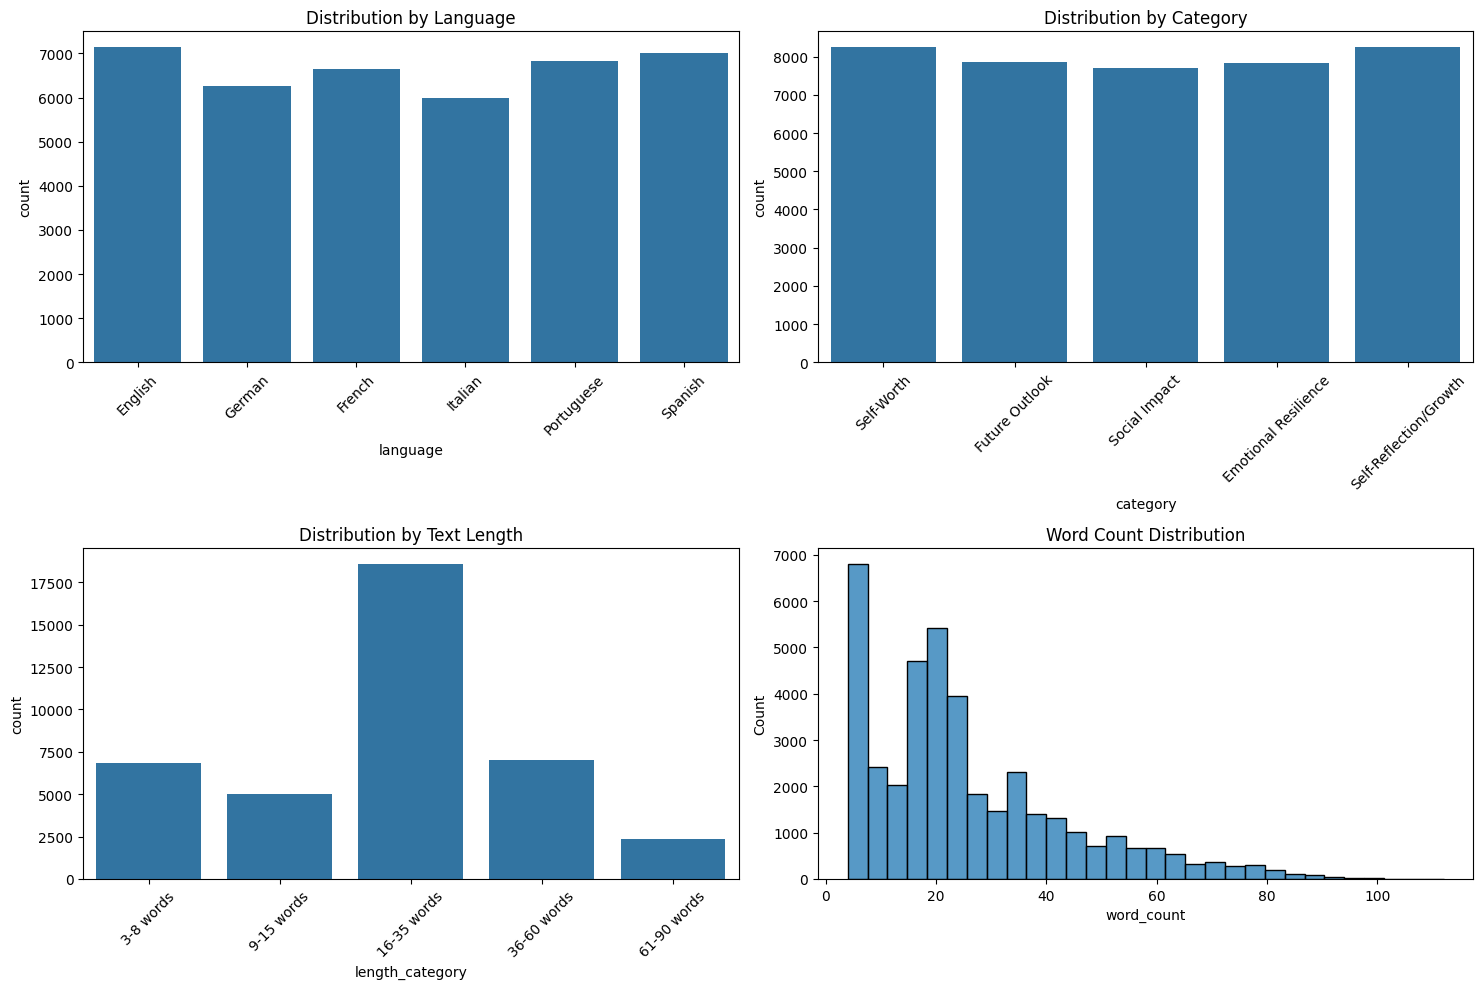

In [160]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Word count distribution analysis
def analyze_text_distribution(df):
    print("\n=== Text Distribution Analysis ===\n")
    
    # Define word count ranges
    df['length_category'] = pd.cut(df['word_count'], 
                                 bins=[0, 8, 15, 35, 60, 90], 
                                 labels=['3-8 words', '9-15 words', '16-35 words', '36-60 words', '61-90 words'])
    
    # Overall statistics
    total_texts = len(df)
    print(f"Total number of texts: {total_texts:,}")
    
    # Language distribution
    print("\n1. Distribution by Language:")
    lang_dist = df['language'].value_counts()
    lang_percentages = (lang_dist / total_texts * 100).round(2)
    for lang, pct in lang_percentages.items():
        print(f"{lang}: {lang_dist[lang]:,} texts ({pct}%)")

    # Mental state distribution
    print("\n2. Distribution by Mental state:")
    mental_state_dist = df['mental_state'].value_counts()
    mental_state_percentages = (mental_state_dist / total_texts * 100).round(2)
    for mental_state, pct in mental_state_percentages.items():
        print(f"{mental_state}: {mental_state_dist[mental_state]:,} texts ({pct}%)")
    
    # Category distribution
    print("\n3. Distribution by Category:")
    cat_dist = df['category'].value_counts()
    cat_percentages = (cat_dist / total_texts * 100).round(2)
    for cat, pct in cat_percentages.items():
        print(f"{cat}: {cat_dist[cat]:,} texts ({pct}%)")
    
    # Word count distribution
    print("\n4. Distribution by Text Length:")
    length_dist = df['length_category'].value_counts()
    length_percentages = (length_dist / total_texts * 100).round(2)
    for length, pct in length_percentages.items():
        print(f"{length}: {length_dist[length]:,} texts ({pct}%)")

    # Cross-tabulation analysis
    print("\n5. Texts per Language and Category:")
    lang_cat_dist = pd.crosstab(df['language'], df['category'])
    print(lang_cat_dist)
    
    print("\n6. Texts per Language and Length:")
    lang_length_dist = pd.crosstab(df['language'], df['length_category'])
    print(lang_length_dist)
    
    # Create visualizations
    plt.figure(figsize=(15, 10))
    
    # Language distribution plot
    plt.subplot(2, 2, 1)
    sns.countplot(data=df, x='language')
    plt.title('Distribution by Language')
    plt.xticks(rotation=45)
    
    # Category distribution plot
    plt.subplot(2, 2, 2)
    sns.countplot(data=df, x='category')
    plt.title('Distribution by Category')
    plt.xticks(rotation=45)
    
    # Length distribution plot
    plt.subplot(2, 2, 3)
    sns.countplot(data=df, x='length_category')
    plt.title('Distribution by Text Length')
    plt.xticks(rotation=45)
    
    # Word count distribution
    plt.subplot(2, 2, 4)
    sns.histplot(data=df, x='word_count', bins=30)
    plt.title('Word Count Distribution')
    
    plt.tight_layout()
    plt.show()
    
    return df

# Run the analysis
df_analyzed = analyze_text_distribution(full_df)